## $2*m*[0.5 - \frac{1}{1 + e^{{ax}^b}}]$

In [77]:
import math
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import ElasticNet,Lasso,Ridge,LinearRegression,ElasticNetCV,LassoCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [4]:
input_data = pd.read_excel('./CellSage-based analyses (selected XCEL cells) (003) (version 1).xlsx')

In [6]:
data1 = input_data.iloc[1:,15:18].dropna()
data1.columns = data1.loc[1]
data1 = data1.loc[2:]
data1

1,"Time, Weeks",Cycles,"Capacity loss, %"
2,0,0,0
3,0.0347222,2.1875,1.65181
4,0.0713046,4.49219,2.53616
5,0.107887,6.79688,3.24085
6,0.144469,9.10156,3.84786
...,...,...,...
215,7.79018,490.781,19.8576
216,7.82676,493.086,19.8648
217,7.86334,495.391,19.872
218,7.89993,497.695,19.879


In [30]:
class SRE:
    def __init__(self,a,b,m,mc,mc_ml):
        self.a = a
        self.b = b
        self.m = m
        self.mc = mc
        self.mc_ml = mc_ml
        
    def expandgrid(self):
            product = list(itertools.product(list(np.ravel(self.a)),list(np.ravel(self.b)),list(np.ravel(self.m))))
            df = pd.DataFrame(product)
            arr_a = np.array(df[0])
            arr_b = np.array(df[1])
            arr_m = np.array(df[2])
            return arr_a,arr_b,arr_m
        
    def single_sre(self,a,b,m,mc):
        try:
            z = 1 + math.exp((a * mc)**b)
            f = 2* m * (0.5 - (1/z))
            return f
        except OverflowError:
            z = float('inf')
            return z
    
    def dataframe_of_inputs(self):
        sre_input_df = pd.DataFrame({'a':pd.Series(self.a),
                              'b':pd.Series(self.b),
                              'm':pd.Series(self.m)})
        
        
        array_input = np.meshgrid(self.a,self.b,self.m)
        return array_input,sre_input_df
        
    def multiple_SRE(self):
        fout = {}
        new_a,new_b,new_m = self.expandgrid()
        for i in range(len(self.mc)):
            z = np.exp(np.power(np.multiply(new_a,self.mc[i]),new_b))
            f = np.multiply(2,np.multiply(new_m,np.subtract(0.5,np.divide(1,np.add(1,z)))))
            fout.update({i:f})
        multi_sre_df = pd.DataFrame(fout).T
        multi_sre_df.index = ['mc{}'.format(i) for i in range(len(fout.keys()))]
        new_input_df = pd.DataFrame({'new_a':new_a,
                                    'new_b':new_b,
                                    'new_m':new_m})
        return multi_sre_df,fout,new_input_df

    def eNet(self,input_X,input_Y,cv=5,l1_ratio=0,random_state=0):
        
        x_train,x_test,y_train,y_test = train_test_split(input_X,input_Y,test_size=0.05,random_state=random_state)
#         x_train,x_test,y_train,y_test = x_train,x_test,y_train.reshape(-1,1),y_test.reshape(-1,1)
        
        Elastic_Net_CV = ElasticNetCV(cv=cv, random_state=random_state)
        Elastic_Net_CV.fit(x_train, y_train)

        # add best_alpha
        #### add coefficients
        # add best_alpha
        predictions_train   = Elastic_Net_CV.predict(x_train) 
        predictions_test    = Elastic_Net_CV.predict(x_test)

        RMSE_train     = np.round(np.sqrt(mean_squared_error(y_train, predictions_train)), 4 )
        RMSE_test      = np.round(np.sqrt(mean_squared_error(y_test, predictions_test)), 4 )

        R_Sq_train     = np.round(Elastic_Net_CV.score(x_train, y_train), 4 )
        R_Sq_test      = np.round(Elastic_Net_CV.score(x_test, y_test), 4 )

        Adj_R_Sq_train  = np.round(1-(1-R_Sq_train) * 
                            (len(y_train)-1) / (len(y_train) - x_train.shape[1]-1), 4 )
        Adj_R_Sq_test  = np.round(1-(1-R_Sq_test) * 
                            (len(y_test)-1) / (len(y_test) - x_test.shape[1]-1), 4 )

        results_metrics = pd.DataFrame({ 'Training Metrics': [RMSE_train, R_Sq_train, Adj_R_Sq_train],
                                           'Training Metrics': [RMSE_test,  R_Sq_test,  Adj_R_Sq_test ]}, 
                                                index = ['RMSE', 'R_Squared', 'Adj_R_Squared'])
        return results_metrics # as dict

In [34]:
if __name__ == '__main__':
    sre = SRE(a = np.linspace( 0.0001, 0.1,3),
              b = np.linspace(0.5,1,3),
              m = np.linspace(0.1,0.3,3),
              mc = list(data1['Cycles']),
              mc_ml = list(data1['Capacity loss, %']))
    exp = sre.expandgrid()
    multiple_sre_output,fout,new_inputdf = sre.multiple_SRE()
    array_input,df_input = sre.dataframe_of_inputs()
    single_sre_output = []
    for i in range(0,501):
        single_sre_output.append(sre.single_sre(a=1.0,b=1.0,m=1.0,mc=i))

In [165]:
# multiple_sre_output

# for i in multiple_sre_output.columns:
# metrics = sre.eNet(input_X=multiple_sre_output.iloc[:,0:1],input_Y=data1['Capacity loss, %'])

# metrics.loc['R_Squared']

# new_inputdf

In [166]:
# print(All_rsquares.index(top_3_rsqs.loc[0].values[0]))
# print(All_rsquares.index(top_3_rsqs.loc[1].values[0]))
# print(All_rsquares.index(top_3_rsqs.loc[2].values[0]))
# multiple_sre_output.iloc[:,All_rsquares.index(top_3_rsqs.loc[0].values[0])]

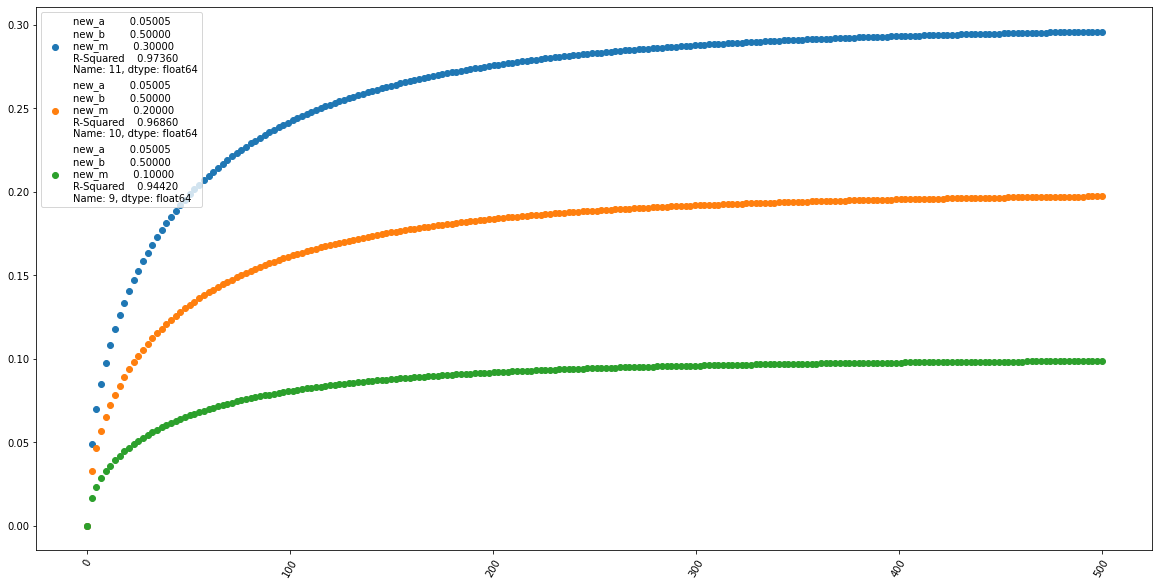

In [172]:
# Appending all RSquares in one list
All_rsquares = []
for i in multiple_sre_output:
    metrics = sre.eNet(input_X=multiple_sre_output.iloc[:,i:i+1],input_Y=data1['Capacity loss, %'])
    r_sq = metrics.loc['R_Squared'].values[0]
    All_rsquares.append(r_sq)

# Creating Dataframe with R Sqaures
top_3_rsqs = pd.DataFrame(sorted(All_rsquares,reverse=True),columns=['R_Squared'],index=range(len(All_rsquares))).head(3)
new_inputdf['R-Squared'] = All_rsquares

plt.figure(figsize=(20,10))
plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares.index(top_3_rsqs.loc[0].values[0])])

plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares.index(top_3_rsqs.loc[1].values[0])])

plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares.index(top_3_rsqs.loc[2].values[0])])

plt.xticks(rotation=60)
plt.legend([str(new_inputdf.loc[All_rsquares.index(top_3_rsqs.loc[0].values[0])]),
            str(new_inputdf.loc[All_rsquares.index(top_3_rsqs.loc[1].values[0])]),
            str(new_inputdf.loc[All_rsquares.index(top_3_rsqs.loc[2].values[0])])])
plt.show()

# Multicolinearity

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [9]:
sc = StandardScaler()

In [10]:
X_new = sc.fit_transform(multiple_sre_output)

In [11]:
X_new.shape,type(X_new)

((50, 25), numpy.ndarray)

In [12]:
np.array(multiple_sre_output).shape

(50, 25)

In [13]:
multiple_sre_output.shape,type(multiple_sre_output)

((50, 25), pandas.core.frame.DataFrame)

In [14]:
vif = pd.DataFrame()

In [16]:
vif['features'] = multiple_sre_output.keys()
vif['factors']= [variance_inflation_factor(np.array(multiple_sre_output),i) for i in range(25)]
vif['factors1']= [variance_inflation_factor(X_new,i) for i in range(25)]

In [17]:
multiple_sre_output[vif['features'][vif['factors'].isna()]]

,0,5,10,15,20
mc0,0.0,0.0,0.0,0.0,0.0
mc1,0.0,0.0,0.0,0.0,0.0
mc2,0.0,0.0,0.0,0.0,0.0
mc3,0.0,0.0,0.0,0.0,0.0
mc4,0.0,0.0,0.0,0.0,0.0
mc5,0.0,0.0,0.0,0.0,0.0
mc6,0.0,0.0,0.0,0.0,0.0
mc7,0.0,0.0,0.0,0.0,0.0
mc8,0.0,0.0,0.0,0.0,0.0
mc9,0.0,0.0,0.0,0.0,0.0


In [23]:
vif[vif['factors1']<10] # 

,features,factors,factors1
3,3,0.0,1.0


In [24]:
vif[vif['factors']<10]

,features,factors,factors1
1,1,0.0,NaN
2,2,0.0,NaN
3,3,0.0,1.0
4,4,0.0,NaN


In [19]:
vif

,features,factors,factors1
0,0,NaN,NaN
1,1,0.0,NaN
2,2,0.0,NaN
3,3,0.0,1.0
4,4,0.0,NaN
5,5,NaN,NaN
6,6,inf,inf
7,7,inf,inf
8,8,inf,inf
9,9,inf,inf


# PCA

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(0.99)

In [27]:
X = pca.fit_transform(multiple_sre_output)

In [28]:
pca.explained_variance_ratio_

array([0.96107989, 0.03864809])

In [29]:
pd.DataFrame(X)

,0,1
0,0.215396,0.048048
1,0.095336,-0.008137
2,0.078462,-0.009981
3,0.067283,-0.010536
4,0.058684,-0.010619
5,0.051597,-0.010471
6,0.045518,-0.010192
7,0.040163,-0.009833
8,0.035358,-0.009422
9,0.030986,-0.008978


In [30]:
new_inputdf

,new_a,new_b,new_m
0,0.0004,0.00,0.00
1,0.0004,0.00,0.15
2,0.0004,0.00,0.30
3,0.0004,0.00,0.45
4,0.0004,0.00,0.60
5,0.0004,0.15,0.00
6,0.0004,0.15,0.15
7,0.0004,0.15,0.30
8,0.0004,0.15,0.45
9,0.0004,0.15,0.60
